In [1]:


# Kaustav Vats (2016048)
from __future__ import division
import numpy as np
from utils import mnist_reader
import pathlib
from math import log
import matplotlib.pyplot as plt



In [2]:


# Load Dataset
X_train, Y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, Y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

def Binarize(arr):
    NewArr = np.zeros((arr.shape[0], arr.shape[1]), dtype=np.int)
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[i, j] <= 127:
                NewArr[i, j] = 0
            else:
                NewArr[i, j] = 1
    return NewArr

if pathlib.Path('xtrain.npy').exists():
    X_train = np.load('xtrain.npy')
else:
    X_train = Binarize(X_train)
    np.save('xtrain.npy', X_train)

if pathlib.Path('xtest.npy').exists():
    X_test = np.load('xtest.npy')
else:
    X_test = Binarize(X_test)
    np.save('xtest.npy', X_test)



In [3]:


print(Y_train)
print("Y_train.shape: ", Y_train.shape)
print("Y_train.size: ", Y_train.size)

print(Y_test)
print("ndim: ", X_train.ndim)
print("shape:", X_train.shape)
print("size: ", X_train.size)

print("ndim: ", Y_train.ndim)
print("shape:", Y_train.shape)
print("size: ", Y_train.size)



[9 0 0 ... 3 0 5]
Y_train.shape:  (60000,)
Y_train.size:  60000
[9 2 1 ... 8 1 5]
ndim:  2
shape: (60000, 784)
size:  47040000
ndim:  1
shape: (60000,)
size:  60000


In [4]:


# Naive Bayes Implementation

class NaiveBayes:
    def __init__(self, ClassCount):
        self.ClassCount = ClassCount
        self.Prob = np.zeros((10, 784, 2))
        self.Pred = np.zeros(10)
        self.PredictedClass = np.zeros((10000,), dtype=np.int)
        self.ConfusionMatrix = np.zeros((10, 10), dtype=np.int)
        self.CalProb = np.zeros((10000, 10))
        
    def fit(self, x_train, y_train):
        if pathlib.Path('Prob.npy').exists():
            self.Prob = np.load('Prob.npy')
        else:
            print(x_train.shape[0], "x", x_train.shape[1])
            for i in range(0, x_train.shape[0]):
                for j in range(0, x_train.shape[1]):
                    if x_train[i, j] == 0:
                        self.Prob[y_train[i], j, 0] += 1
                    else:
                        self.Prob[y_train[i], j, 1] += 1
            self.Prob = self.Prob/6000
            np.save('Prob.npy', self.Prob)

    def predict(self, x_test, y_test):
        if pathlib.Path('CalProb.npy').exists():
            self.CalProb = np.load('CalProb.npy')
        else:
            Correct = 0
            print(x_test.shape[0], "x", x_test.shape[1])
            for i in range(x_test.shape[0]):
                self.Pred = np.zeros(10)
                for j in range(self.ClassCount):
                    num = 1.0
                    for k in range(x_test.shape[1]):
                        # print("x_test:", x_test[i, k])
                        # print(num, self.Prob[j, k, x_test[i, k]])
                        num = num*self.Prob[j, k, x_test[i, k]]
                    num = num*0.1
                    self.Pred[j] = num
                # print(self.Pred)
                ac = np.argmax(self.Pred)
                self.PredictedClass[i] = ac
                if ac == y_test[i]:
                    Correct += 1
                
                self.Pred = self.Pred/(np.sum(self.Pred))
                # print("self.Pred avg value:", np.average(self.Pred))
                for n in range(self.ClassCount):
                    self.CalProb[i, n] = self.Pred[n]
            print(Correct/10000)
            np.save('CalProb.npy', self.CalProb)

    def ConMatrix(self, y_test):
        for i in range(10000):
            self.ConfusionMatrix[y_test[i], self.PredictedClass[i]] += 1
        print(self.ConfusionMatrix)

    # def ConMatrixCustom(self, y_test, class1, class2):
    #     for i in range(self.ConfusionMatrix.shape[0]):
    #         if i == 1 or i == 2:
    #             for j in range(self.ConfusionMatrix.shape[1]):
    #                 if j == 1 or j == 2:
    #                     print(self.ConfusionMatrix[i, j], end=' ')
    #             print()

    def PrecisionAndRecall(self):
        for i in range(self.ClassCount):
            tpfp = 0.0
            for j in range(self.ClassCount):
                tpfp += self.ConfusionMatrix[j, i]
            print("Precision for Class", i, "=", self.ConfusionMatrix[i, i]/tpfp)
            print("Recall for Class", i, "=", self.ConfusionMatrix[i, i]/10000.0)
            print()

    def RocCurve(self, y_test):
        # print(max(self.Prob[5, :, 0]))
        roc_values = np.zeros((10, 2, 1000))
        if pathlib.Path('roc_value.npy').exists():
            roc_values = np.load('roc_value.npy')
        else:
            for i in range(10):
                Threshold = 1.0
                for k in range(1000):
                    tp = 0
                    fn = 0
                    fp = 0
                    tn = 0
                    for j in range(10000):
                        classify = False
                        if ( self.CalProb[j, i] > Threshold ):
                            classify = True
                        if classify and y_test[j] == i:
                            tp += 1
                        elif classify and y_test[j] != i:
                            fp += 1
                        elif classify == False and y_test[j] == i:
                            fn += 1
                        elif classify == False and y_test[j] != i:
                            tn += 1

                    roc_values[i, 0, k] = tp/(tp+fn)
                    roc_values[i, 1, k] = fp/(tn+fp)

                    Threshold *= 0.3
                print("K", k)
            np.save('roc_value.npy', roc_values)

        plt.figure()
        color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#940445', '#42c4d3', '#ff7256']
        for i in range(10):
            plt.plot(roc_values[i, 1, :], roc_values[i, 0, :], color[i], label="ROC Curve for class %d " %i)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc='lower right')
        # plt.show()  
        plt.savefig('roc_q1.png')

    def print(self):
        print(self.Prob[5, :, 0])

In [5]:

# 1 	Trouser
# 2 	Pullover



In [6]:

NB = NaiveBayes(10)
NB.fit(X_train, Y_train)



In [7]:
NB.predict(X_test, Y_test)


In [8]:

NB.ConMatrix(Y_test)
# NB.ConMatrixCustom(Y_test, 1, 2)


[[1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]]


Precision for Class 0 = 0.1
Recall for Class 0 = 0.1

Precision for Class 1 = nan
Recall for Class 1 = 0.0

Precision for Class 2 = nan
Recall for Class 2 = 0.0

Precision for Class 3 = nan
Recall for Class 3 = 0.0

Precision for Class 4 = nan
Recall for Class 4 = 0.0

Precision for Class 5 = nan
Recall for Class 5 = 0.0

Precision for Class 6 = nan
Recall for Class 6 = 0.0

Precision for Class 7 = nan
Recall for Class 7 = 0.0

Precision for Class 8 = nan
Recall for Class 8 = 0.0

Precision for Class 9 = nan
Recall for Class 9 = 0.0



C:\Users\Kvats\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide


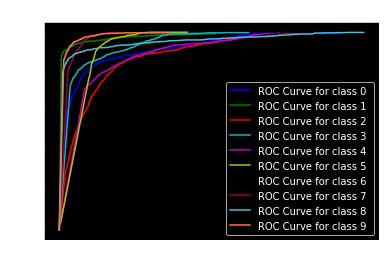

In [9]:

# Finding Precision and Recall
NB.PrecisionAndRecall()
NB.RocCurve(Y_test)


10000 x 784


c:\users\kvats\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


0.932
[[1000    0    0    0    0    0    0    0    0    0]
 [   1  964   35    0    0    0    0    0    0    0]
 [   2   98  900    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]]
Precision for Class 0 = 0.12495314257153567
Recall for Class 0 = 0.1

Precision for Class 1 = 0.9077212806026366
Recall for Class 1 = 0.0964

Precision for Class 2 = 0.9625668449197861
Recall for Class 2 = 0.09

Precision for Class 3 = nan
Recall for Class 3 = 0.0

Precision for Class 4 = nan
Recall for Class 4 = 0.0

Precision for Class 5 = nan
Recall for Class 5 = 0.0

Precision for Class 6 = nan
Recall for Class 6 = 0.0

Precision for Class 7 = nan
Recall 

c:\users\kvats\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


K 999
K 999


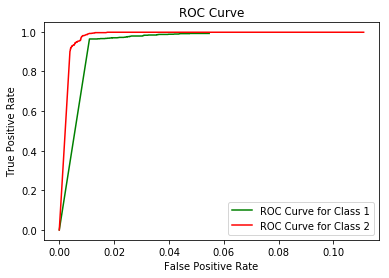

In [4]:

class NaiveBayesCustom:
    def __init__(self, ClassCount):
        self.ClassCount = ClassCount
        self.Prob = np.zeros((10, 784, 2))
        self.Pred = np.zeros(10)
        self.PredictedClass = np.zeros((10000,), dtype=np.int)
        self.ConfusionMatrix = np.zeros((10, 10), dtype=np.int)
        self.CalProb = np.zeros((10000, 10))
        
    def fit(self, x_train, y_train):
        if pathlib.Path('Prob12.npy').exists():
            self.Prob = np.load('Prob12.npy')
        else:
            print(x_train.shape[0], "x", x_train.shape[1])
            for i in range(0, x_train.shape[0]):
                if y_train[i] == 1 or y_train[i] == 2:
                    for j in range(0, x_train.shape[1]):
                        if x_train[i, j] == 0:
                            self.Prob[y_train[i], j, 0] += 1
                        else:
                            self.Prob[y_train[i], j, 1] += 1
            self.Prob = self.Prob/6000
            np.save('Prob12.npy', self.Prob)

    def predict(self, x_test, y_test):
        Correct = 0
        print(x_test.shape[0], "x", x_test.shape[1])
        for i in range(x_test.shape[0]):
            self.Pred = np.zeros(10)
            if y_test[i] == 1 or y_test[i] == 2:
                for j in range(self.ClassCount):
                    num = 1.0
                    for k in range(x_test.shape[1]):
                        # print("x_test:", x_test[i, k])
                        # print(num, self.Prob[j, k, x_test[i, k]])
                        num = num*self.Prob[j, k, x_test[i, k]]
                    num = num*0.5
                    self.Pred[j] = num
                # print(self.Pred)
                ac = np.argmax(self.Pred)
                self.PredictedClass[i] = ac
                if ac == y_test[i]:
                    Correct += 1
                
                self.Pred = self.Pred/(np.sum(self.Pred))
                # print("self.Pred avg value:", np.average(self.Pred))
                for n in range(self.ClassCount):
                    self.CalProb[i, n] = self.Pred[n]
        print(Correct/2000)

    def ConMatrix(self, y_test):
        for i in range(10000):
            self.ConfusionMatrix[y_test[i], self.PredictedClass[i]] += 1
        print(self.ConfusionMatrix)

    # def ConMatrixCustom(self, y_test, class1, class2):
    #     for i in range(self.ConfusionMatrix.shape[0]):
    #         if i == 1 or i == 2:
    #             for j in range(self.ConfusionMatrix.shape[1]):
    #                 if j == 1 or j == 2:
    #                     print(self.ConfusionMatrix[i, j], end=' ')
    #             print()

    def PrecisionAndRecall(self):
        for i in range(self.ClassCount):
            tpfp = 0.0
            for j in range(self.ClassCount):
                tpfp += self.ConfusionMatrix[j, i]
            print("Precision for Class", i, "=", self.ConfusionMatrix[i, i]/tpfp)
            print("Recall for Class", i, "=", self.ConfusionMatrix[i, i]/10000.0)
            print()

    def RocCurve(self, y_test, c1, c2):
        # print(max(self.Prob[5, :, 0]))
        roc_values = np.zeros((10, 2, 1000))
        for i in range(10):
            if i == c1 or i == c2:
                Threshold = 1.0
                for k in range(1000):
                    tp = 0
                    fn = 0
                    fp = 0
                    tn = 0
                    for j in range(10000):
                        classify = False
                        if ( self.CalProb[j, i] > Threshold ):
                            classify = True
                        if classify and y_test[j] == i:
                            tp += 1
                        elif classify and y_test[j] != i:
                            fp += 1
                        elif classify == False and y_test[j] == i:
                            fn += 1
                        elif classify == False and y_test[j] != i:
                            tn += 1

                    roc_values[i, 0, k] = tp/(tp+fn)
                    roc_values[i, 1, k] = fp/(tn+fp)

                    Threshold *= 0.3
                print("K", k)

        plt.figure()
        color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#940445', '#42c4d3', '#ff7256']
        for i in range(10):
            if i == c2 or i == c1:
                plt.plot(roc_values[i, 1, :], roc_values[i, 0, :], color[i], label="ROC Curve for Class %d" %i)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc='lower right')
        # plt.show()  
        plt.savefig("roc_q11.png")


NB = NaiveBayesCustom(10)
NB.fit(X_train, Y_train)
NB.predict(X_test, Y_test)
NB.ConMatrix(Y_test)
NB.PrecisionAndRecall()
NB.RocCurve(Y_test, 1, 2)


In [11]:

class NaiveBayesCustom:
    def __init__(self, ClassCount):
        self.ClassCount = ClassCount
        self.Prob = np.zeros((10, 784, 2))
        self.Pred = np.zeros(10)
        self.PredictedClass = np.zeros((10000,), dtype=np.int)
        self.ConfusionMatrix = np.zeros((10, 10), dtype=np.int)
        self.CalProb = np.zeros((10000, 10))
        
    def fit(self, x_train, y_train):
        if pathlib.Path('Prob12.npy').exists():
            self.Prob = np.load('Prob12.npy')
        else:
            print(x_train.shape[0], "x", x_train.shape[1])
            for i in range(0, x_train.shape[0]):
                if y_train[i] == 1 or y_train[i] == 2:
                    for j in range(0, x_train.shape[1]):
                        if x_train[i, j] == 0:
                            self.Prob[y_train[i], j, 0] += 1
                        else:
                            self.Prob[y_train[i], j, 1] += 1
            self.Prob = self.Prob/6000
            np.save('Prob12.npy', self.Prob)

    def predict(self, x_test, y_test):
        Correct = 0
        print(x_test.shape[0], "x", x_test.shape[1])
        for i in range(x_test.shape[0]):
            self.Pred = np.zeros(10)
            if y_test[i] == 1 or y_test[i] == 2:
                for j in range(self.ClassCount):
                    num = 1.0
                    for k in range(x_test.shape[1]):
                        # print("x_test:", x_test[i, k])
                        # print(num, self.Prob[j, k, x_test[i, k]])
                        num = num*self.Prob[j, k, x_test[i, k]]
                    num = num*0.5
                    self.Pred[j] = num
                # print(self.Pred)
                ac = np.argmax(self.Pred)
                self.PredictedClass[i] = ac
                if ac == y_test[i]:
                    Correct += 1
                
                self.Pred = self.Pred/(np.sum(self.Pred))
                # print("self.Pred avg value:", np.average(self.Pred))
                for n in range(self.ClassCount):
                    self.CalProb[i, n] = self.Pred[n]
        print(Correct/2000)

    def ConMatrix(self, y_test):
        for i in range(10000):
            self.ConfusionMatrix[y_test[i], self.PredictedClass[i]] += 1
        print(self.ConfusionMatrix)

    # def ConMatrixCustom(self, y_test, class1, class2):
    #     for i in range(self.ConfusionMatrix.shape[0]):
    #         if i == 1 or i == 2:
    #             for j in range(self.ConfusionMatrix.shape[1]):
    #                 if j == 1 or j == 2:
    #                     print(self.ConfusionMatrix[i, j], end=' ')
    #             print()

    def PrecisionAndRecall(self):
        for i in range(self.ClassCount):
            tpfp = 0.0
            for j in range(self.ClassCount):
                tpfp += self.ConfusionMatrix[j, i]
            print("Precision for Class", i, "=", self.ConfusionMatrix[i, i]/tpfp)
            print("Recall for Class", i, "=", self.ConfusionMatrix[i, i]/10000.0)
            print()

    def RocCurve(self, y_test, c1, c2):
        # print(max(self.Prob[5, :, 0]))
        roc_values = np.zeros((10, 2, 1000))
        for i in range(10):
            if i == c1 or i == c2:
                Threshold = 1.0
                for k in range(1000):
                    tp = 0
                    fn = 0
                    fp = 0
                    tn = 0
                    for j in range(10000):
                        classify = False
                        if ( self.CalProb[j, i] > Threshold ):
                            classify = True
                        if classify and y_test[j] == i:
                            tp += 1
                        elif classify and y_test[j] != i:
                            fp += 1
                        elif classify == False and y_test[j] == i:
                            fn += 1
                        elif classify == False and y_test[j] != i:
                            tn += 1

                    roc_values[i, 0, k] = tp/(tp+fn)
                    roc_values[i, 1, k] = fp/(tn+fp)

                    Threshold *= 0.3
                print("K", k)

        plt.figure()
        color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#940445', '#42c4d3', '#ff7256']
        for i in range(10):
            if i == c2 or i == c1:
                plt.plot(roc_values[i, 1, :], roc_values[i, 0, :], color[i], label="ROC Curve for Class %d" %i)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc='lower right')
        # plt.show()  
        plt.savefig("roc_q11.png")


NB = NaiveBayesCustom(10)
NB.fit(X_train, Y_train)
NB.predict(X_test, Y_test)
NB.ConMatrix(Y_test)
NB.PrecisionAndRecall()
NB.RocCurve(Y_test, 1, 2)


10000 x 784


C:\Users\Kvats\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


0.932
[[1000    0    0    0    0    0    0    0    0    0]
 [   1  964   35    0    0    0    0    0    0    0]
 [   2   98  900    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]]
Precision for Class 0 = 0.12495314257153567
Recall for Class 0 = 0.1

Precision for Class 1 = 0.9077212806026366
Recall for Class 1 = 0.0964

Precision for Class 2 = 0.9625668449197861
Recall for Class 2 = 0.09

Precision for Class 3 = nan
Recall for Class 3 = 0.0

Precision for Class 4 = nan
Recall for Class 4 = 0.0

Precision for Class 5 = nan
Recall for Class 5 = 0.0

Precision for Class 6 = nan
Recall for Class 6 = 0.0

Precision for Class 7 = nan
Recall 

C:\Users\Kvats\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
